Using the old model prior to meeting to verify the recreation of the results.

In [72]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.theoretical as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import utils.expectation_values as expect
importlib.reload(expect)

pass

1.4181020408163265


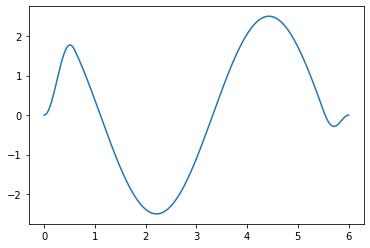

In [132]:
offset = 0.03189795918367347
tlist = np.linspace(0, 6, 2000)
print(system.first_energy_spacing/3 - offset)
pulse_gen.setup(amplitude=2.5, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=0.2, tlist=tlist)
plt.plot(tlist, pulse_gen.get_pulse(tlist))

In [133]:
tlist = np.linspace(0, 100, 100*10)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=True)

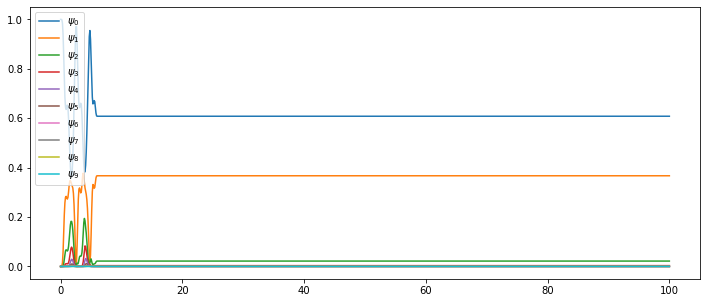

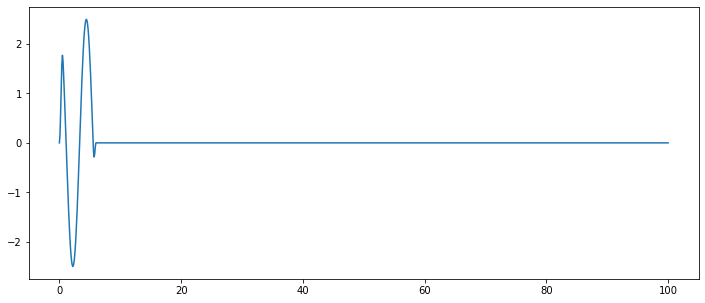

In [134]:
expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
fig, ax = plt.subplots(figsize=(12, 5))
for i in range(0, len(expectation_values)):
    ax.plot(tlist, expectation_values[i], label="$\psi_{%i}$" % i)
plt.legend()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tlist, pulse_gen.get_pulse(tlist))

In [101]:
expectation_values[1][-1]

0.9702539841388396

In [82]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
all_results = []
_amp = 2.5
_off = 0
_dur = 200

# Vary Offset

In [102]:
def vary_offset(off):
    tlist = np.linspace(0, _dur, int(_dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(0, 1, 50)
offset_varying_results = parfor(vary_offset, offs_to_test)

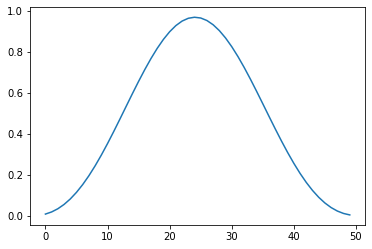

In [105]:
_fids_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])

plt.plot(_fids_off_sweep)
plt.show()
best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 50)
offset_varying_results = parfor(vary_offset, offs_to_test)

In [114]:
best_result = offset_varying_results[np.argmax(_fids_off_sweep)]
best_result

{'fidelity': 0.9689702548829136,
 'offset': 0.03163265306122448,
 'frequency': 1.4183673469387754,
 'duration': 200,
 'amplitude': 2.5}

# Fidelity Landscape

In [118]:
def run_once(dur):
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=0.5, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": dur,
        "amplitude": _amp
    }

for off in np.linspace(best_result["offset"] - 0.01, best_result["offset"] + 0.01, 50):
    print(off)
    _off = off
    already_did_this_offset = False
    for result in all_results:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    all_results += parallel_map(run_once, np.linspace(500, 500+495+495, 100)) # , progress_bar=True

0.02163265306122448
0.022040816326530602
0.022448979591836723
0.022857142857142847
0.023265306122448967
0.02367346938775509
0.024081632653061215
0.024489795918367335
0.02489795918367346
0.025306122448979583
0.025714285714285703
0.026122448979591827
0.026530612244897948
0.02693877551020407
0.027346938775510192
0.027755102040816316
0.02816326530612244
0.02857142857142856
0.028979591836734684
0.029387755102040808
0.02979591836734693
0.030204081632653052
0.030612244897959176
0.031020408163265296
0.03142857142857142
0.031836734693877544
0.032244897959183665
0.032653061224489785
0.03306122448979591
0.03346938775510203
0.03387755102040815
0.03428571428571428
0.0346938775510204
0.03510204081632652
0.03551020408163264
0.03591836734693877
0.03632653061224489
0.03673469387755101
0.03714285714285713
0.03755102040816326
0.03795918367346938
0.0383673469387755
0.038775510204081626
0.039183673469387746
0.03959183673469387
0.039999999999999994
0.040408163265306114
0.040816326530612235
0.041224489795918

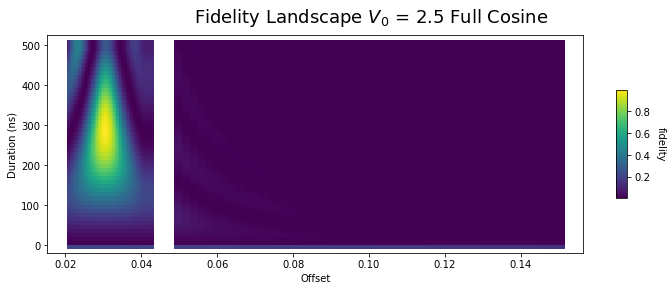

In [117]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
all_results_to_graph = copy.deepcopy(all_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])

fig, axs = plt.subplots(figsize=(12, 4))
fig.suptitle("Fidelity Landscape $V_0$ = %.1f Full Cosine" % amps[-1], fontsize=18)
axs.set_xlabel("Offset")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(offs, np.array(durs), c=fids, cmap=None, marker="s", s=100)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

In [120]:
all_results2 = []
for off in np.linspace(best_result["offset"] - 0.01, best_result["offset"] + 0.01, 50):
    print(off)
    _off = off
    already_did_this_offset = False
    for result in all_results2:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    all_results2 += parallel_map(run_once, np.linspace(500, 500+495+495, 100)) # , progress_bar=True

0.02163265306122448
0.022040816326530602
0.022448979591836723
0.022857142857142847
0.023265306122448967
0.02367346938775509
0.024081632653061215
0.024489795918367335
0.02489795918367346
0.025306122448979583
0.025714285714285703
0.026122448979591827
0.026530612244897948
0.02693877551020407
0.027346938775510192
0.027755102040816316
0.02816326530612244
0.02857142857142856
0.028979591836734684
0.029387755102040808
0.02979591836734693
0.030204081632653052
0.030612244897959176
0.031020408163265296
0.03142857142857142
0.031836734693877544
0.032244897959183665
0.032653061224489785
0.03306122448979591
0.03346938775510203
0.03387755102040815
0.03428571428571428
0.0346938775510204
0.03510204081632652
0.03551020408163264
0.03591836734693877
0.03632653061224489
0.03673469387755101
0.03714285714285713
0.03755102040816326
0.03795918367346938
0.0383673469387755
0.038775510204081626
0.039183673469387746
0.03959183673469387
0.039999999999999994
0.040408163265306114
0.040816326530612235
0.041224489795918

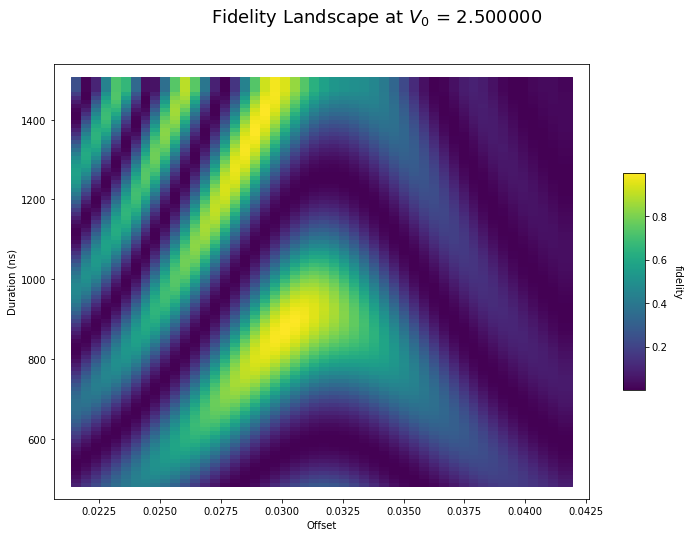

In [121]:
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
for result in all_results2:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])

fig, axs = plt.subplots(figsize=(12, 8))
fig.suptitle("Fidelity Landscape at $V_0$ = %f " % amps[-1], fontsize=18)
axs.set_xlabel("Offset")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(offs, np.array(durs), c=fids, cmap=None, marker="s", s=200)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

In [26]:
import utils.saver as saver

saver.save(all_results2, "theoretical_landscape_5-5")